In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from catboost import CatBoost
from catboost.utils import eval_metric

# Функция чтобы объединить разные сигналы в один

In [2]:
def create_dataset (path):
    data_set = []
    for i in path:
        data = pd.read_csv(i)
        data_set.extend(data[data.columns[1]][0:10000])
    return pd.DataFrame(data_set)

# Прописываем какие сигналы будем брать для обучения. По итогу я взял 9 сигналов, старался выбрать наиболее отличающиеся друг от друга. Файлы из дасета надо проверять, потому что там в некоторых не экг, а дыхательный сигнал. Сначала всё подряд закидывал в обучение.

In [4]:
path = ['100.csv', '101.csv',  '103.csv','109.csv', '113.csv', '121.csv', '122.csv', '205.csv', '214.csv']
signal = create_dataset(path)
signal = signal[0]

(0.0, 1000.0)

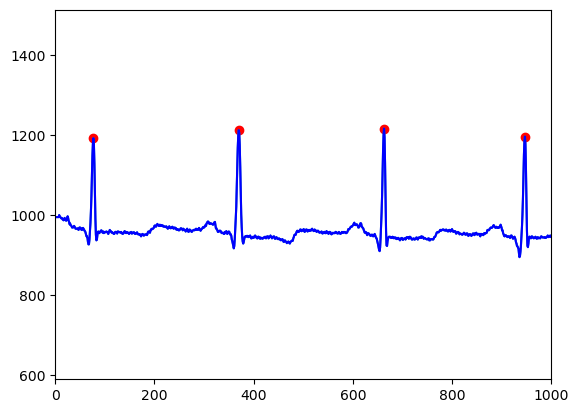

In [5]:
plt.plot(signal)
peaks = find_peaks(signal, distance=200)
plt.plot(signal, color = 'blue')
plt.scatter(peaks[0], signal[peaks[0]], color='red')
plt.xlim(0,1000)

In [6]:
window = 200
dataset = []
middles = []
for i in range(0, len(signal)-window, 4):
    piece = signal[i:i+window] / np.max(np.abs(signal[i:i+window]))
    piece = piece - np.mean(piece)
    is_peak = 0
    middle = (i + i + window) / 2
    for peak in peaks[0]:
        if peak >= middle - 2 and peak < middle + 2:
            is_peak = 1
            middles.append(middle)
            break
    piece = np.append(piece, is_peak)
    dataset.append(piece)

In [7]:
df = pd.DataFrame(dataset)
X_train, X_test, Y_train, Y_test = train_test_split(df.iloc[: , :200], df[200], test_size = 0.15)

booster = CatBoost(params={'iterations':99, 'loss_function':'Logloss'})

booster.fit(X_train, Y_train, eval_set=(X_test, Y_test))
booster.set_feature_names([str(i) for i in range(200)])

test_preds = booster.predict(X_test, prediction_type="Class")
train_preds = booster.predict(X_train, prediction_type="Class")

Learning rate set to 0.179524
0:	learn: 0.3022191	test: 0.3041014	best: 0.3041014 (0)	total: 171ms	remaining: 16.8s
1:	learn: 0.1366395	test: 0.1383367	best: 0.1383367 (1)	total: 209ms	remaining: 10.1s
2:	learn: 0.0749350	test: 0.0762626	best: 0.0762626 (2)	total: 257ms	remaining: 8.22s
3:	learn: 0.0386060	test: 0.0397956	best: 0.0397956 (3)	total: 298ms	remaining: 7.09s
4:	learn: 0.0277414	test: 0.0289874	best: 0.0289874 (4)	total: 340ms	remaining: 6.39s
5:	learn: 0.0190844	test: 0.0208991	best: 0.0208991 (5)	total: 385ms	remaining: 5.97s
6:	learn: 0.0153508	test: 0.0177360	best: 0.0177360 (6)	total: 438ms	remaining: 5.76s
7:	learn: 0.0122663	test: 0.0153258	best: 0.0153258 (7)	total: 495ms	remaining: 5.63s
8:	learn: 0.0103394	test: 0.0136483	best: 0.0136483 (8)	total: 545ms	remaining: 5.45s
9:	learn: 0.0092878	test: 0.0126613	best: 0.0126613 (9)	total: 595ms	remaining: 5.29s
10:	learn: 0.0088619	test: 0.0124703	best: 0.0124703 (10)	total: 651ms	remaining: 5.21s
11:	learn: 0.0079056	t

96:	learn: 0.0009740	test: 0.0109993	best: 0.0100388 (31)	total: 5.68s	remaining: 117ms
97:	learn: 0.0009468	test: 0.0109206	best: 0.0100388 (31)	total: 5.74s	remaining: 58.6ms
98:	learn: 0.0009324	test: 0.0109392	best: 0.0100388 (31)	total: 5.79s	remaining: 0us

bestTest = 0.01003880829
bestIteration = 31

Shrink model to first 32 iterations.


In [8]:
from catboost.utils import eval_metric
print("\nTest  Accuracy : %f"%eval_metric(Y_test.values, test_preds, "Accuracy")[0])
print("Train Accuracy : %f"%eval_metric(Y_train.values, train_preds, "Accuracy")[0])
print(len(Y_test.values))


Test  Accuracy : 0.997328
Train Accuracy : 0.999424
3368


In [9]:
chek_path = ['231.csv', '201.csv', '207.csv', '233.csv']

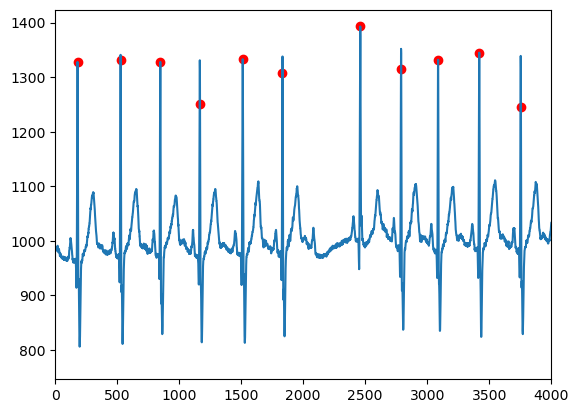

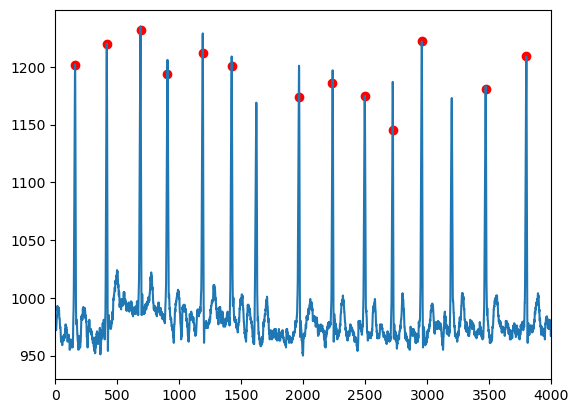

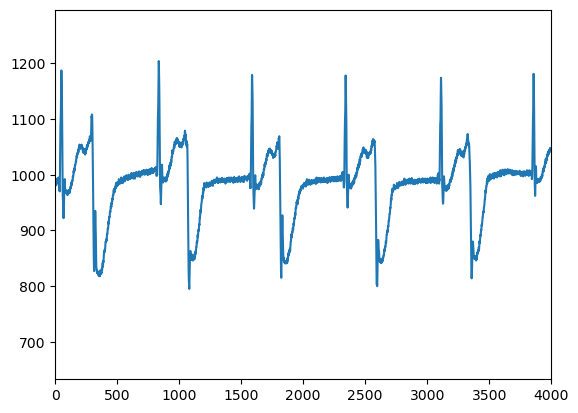

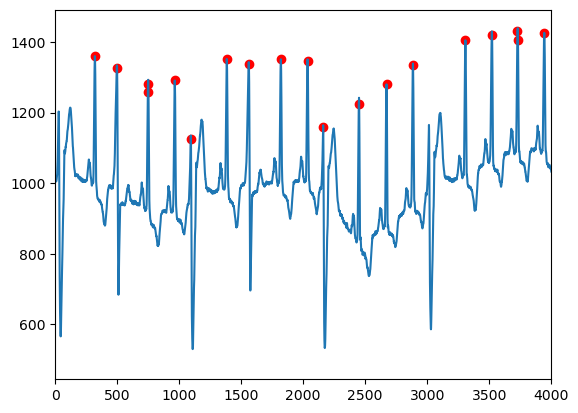

In [17]:
for i in chek_path: 
    data_check = pd.read_csv(i)
    signal_check = data_check[data_check.columns[1]].values
    signal_check = signal_check[0:20000]
    window = 200
    dataset_check = []
    middles_check= []
    for i in range(0, len(signal_check)-window, 4):
        piece = signal_check[i:i+window] / np.max(np.abs(signal_check[i:i+window]))
        piece = piece - np.mean(piece)
        is_peak = 0
        middle = (i + i + window) / 2
        middles_check.append(middle)
        dataset_check.append(piece)
    df_check = pd.DataFrame(dataset_check)
    test_preds1 = booster.predict(df_check, prediction_type="Class")
    peaks_check = np.where(test_preds1>0)[0]
    middles_check = np.asarray(middles_check, dtype=int)
    plt.plot(signal_check)
    plt.scatter(middles_check[peaks_check], signal_check[middles_check[peaks_check]], color='red')
    plt.xlim([0, 4000])
    plt.show()

# Такой результат. На самом необычном сигнале вообще ничего не выделяется. Видимо не было таких специфических файлов в обучающей выборке.